# Scikit-learn Pipelines para PLN

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline # Esta es la clase que usaremos para desarrollar el modelo.
from sklearn.model_selection import cross_val_score
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Conjunto de datos de noticias y nombre del medio

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/giturra/JCC2023-WE/main/noticias_oct_dic_2019.tsv', sep='\t').sample(1000)

In [3]:
data

,texto,medio,fecha
2868,«No podemos estar ajenos a la situación»: ANFP...,CHV,2019-10-22 14:16:00
2515,Greta Thunberg entre las 10 personas más influ...,CHV,2019-12-18 21:51:00
5615,Se encuentra en estado grave : Investigan agre...,El Rancaguino,2019-11-05 10:56:38
1611,Everton igualó con Unión La Calera en un amist...,Cooperativa CL,2019-10-25 12:00:00
7164,Experta en constitución: Partidos “sí han esta...,Radio Concierto,2019-12-09 11:54:01
...,...,...,...
9599,“Es un golpe de estado con elástico”: la renun...,La RED,2019-11-11 16:57:11
52,El Gobierno de Bolivia indemnizará a las famil...,El Mercurio,2019-12-06 03:12:00
8728,[Video] Conductores de CNN Chile se negaron a ...,The Clinic,2019-11-15 21:22:59
4819,Alcalde de San Nicolás responde a críticas por...,La Discusión,2019-11-06 12:39:32


## Preprocesamiento del conjunto de datos

In [4]:
feature = data["texto"]
label = data["medio"]

In [5]:
feature_train, feature_test, label_train, label_test = train_test_split(feature, label)

## Definición del primer Pipeline

Un pipeline son una serie de pasos de transformaciones de datos con un algoritmo de entrenamiento de un modelo al final. Podemos definir todas las funciones de preprocesamiento del texto antes de ajustar el modelo. En el caso de PLN, primero vectorizamos el texto y después lo pasamos por el algoritmo de entrenamiento.

In [6]:
pipe = Pipeline(
    [ # Definimos una lista de pasos que se ejecutarán de manera serial
        ('vectorizer', CountVectorizer()), # Cada paso es una tupla que contiene el nombre del paso y la clase que se ejecutará. La clase debe exponer el método transform.
        ('classifier', RandomForestClassifier()) # Finalmente definimos el algoritmo de entrenamiento del modelo.
        ]
    )

In [7]:
pipe.fit(feature_train, label_train) # El Pipeline expone los mismos métodos que cualquier otro modelo.

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', RandomForestClassifier())])

In [8]:
predicted = pipe.predict(feature_test) # Podemos usar el mismo Pipeline para hacer inferencia sobre los datos crudos y se realizarán todos los preprocesamientos definidos.

In [9]:
print(classification_report(predicted, label_test))

                 precision    recall  f1-score   support

            CHV       0.91      0.48      0.62        42
 Cooperativa CL       0.87      0.87      0.87        31
    El Mercurio       0.30      0.40      0.34        20
  El Rancaguino       0.71      0.71      0.71        24
   La Discusión       0.47      0.53      0.50        15
      La Nación       0.21      0.45      0.29        11
         La RED       0.88      0.58      0.70        48
           MEGA       0.86      1.00      0.93        19
Radio Concierto       0.62      0.76      0.68        21
     The Clinic       0.72      0.95      0.82        19

       accuracy                           0.66       250
      macro avg       0.65      0.67      0.65       250
   weighted avg       0.73      0.66      0.68       250



## Probemos varias combinaciones

In [10]:
def normalize(text, remove_tildes=False):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower()  # Llevamos todo a minúscula
    # Reemplazamos los caracteres no alfabéticos por un espacio
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text)
    if remove_tildes:
        text = re.sub('á', 'a', text)  # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

In [11]:
stopwords_spanish = stopwords.words('spanish')

In [28]:
pipelines = [
    Pipeline([('vectorizer', CountVectorizer()), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', CountVectorizer(preprocessor=normalize)), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer(preprocessor=normalize)), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', CountVectorizer(preprocessor=normalize, stop_words=stopwords_spanish)), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer(preprocessor=normalize, stop_words=stopwords_spanish)), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', CountVectorizer(preprocessor=normalize, stop_words=stopwords_spanish, ngram_range=(1, 2))), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer(preprocessor=normalize, stop_words=stopwords_spanish, ngram_range=(1, 2))), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', CountVectorizer(preprocessor=normalize, stop_words=stopwords_spanish, ngram_range=(1, 3))), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer(preprocessor=normalize, stop_words=stopwords_spanish, ngram_range=(1, 3))), ('classifier', RandomForestClassifier())]),

]

In [29]:
results = []
for pipe in pipelines:
    results.append(
        cross_val_score(pipe, feature_train, label_train, cv=5, scoring='accuracy', n_jobs=-1)
    )

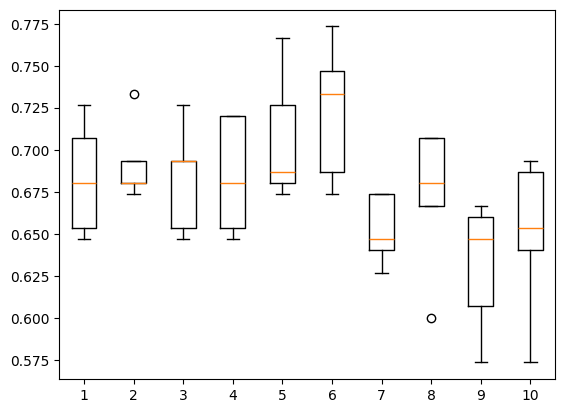

In [30]:
plt.boxplot(results)
plt.show()